Here I investigate the number of significant associations present across different patch sizes.

In [1]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn

In [2]:
mean_features = {}
with h5py.File(GTEx_directory + '/data/retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

# Most features don't vary

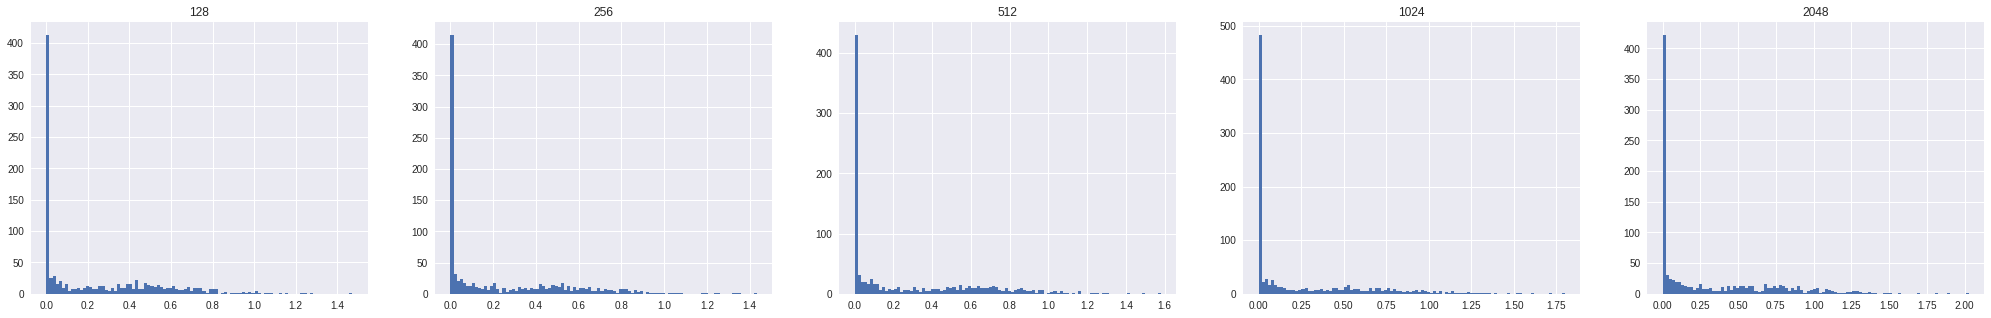

In [3]:
f, a = plt.subplots(1,5, figsize=(35,5))
for (i,s) in enumerate(['128','256','512','1024','2048']):
    a[i].hist(np.std(mean_features[s],axis=0),bins=100)
    a[i].set_title(s)
plt.show()

Which set of features shall we take that do not vary much across all patch sizes?

Even with feature concatenated across different patch sizes, the majority show low variation

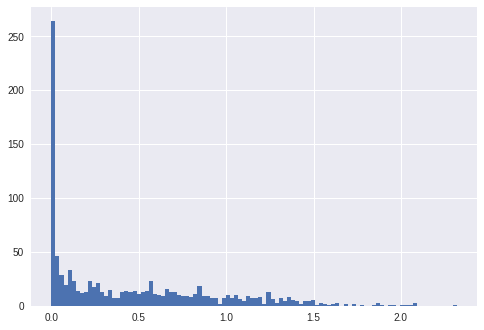

In [4]:
concatenated_features = np.vstack([mean_features['128'], mean_features['256'], mean_features['512'], mean_features['1024'], mean_features['2048']])
plt.hist(np.std(concatenated_features,axis=0),bins=100)
plt.show()

# Most transcripts do not vary

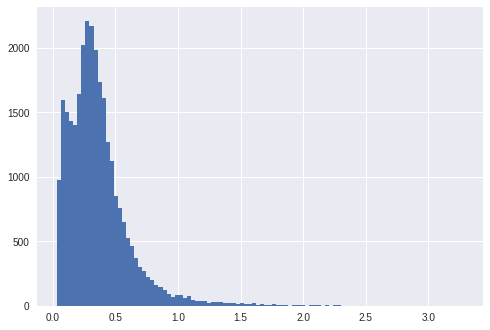

In [5]:
plt.hist(np.std(expression,axis=0),bins=100)
plt.show()

# Choose 100 most varying features. Choose 5000 most varying transcripts

In [137]:
N = 100
M = 5000
most_expressed_transcript_idx = np.argsort(np.std(expression,axis=0))[::-1][:M]
most_varying_feature_idx = np.argsort(np.std(concatenated_features,axis=0))[::-1][:N]

# Raw number of associations for changing FDRs

# Compare across patch sizes and aggregations methods

In [127]:
import pdb

In [139]:
results = {}
aggregations = ['mean','median']
sizes = ['128','256','512','1024','2048']    
for a in aggregations:
    for s in sizes:
        print (a,s)
        with h5py.File(GTEx_directory + '/data/retrained_inceptionet_aggregations.hdf5','r') as f:
            expression = f['lung'][s]['expression'].value
            mean_features = f['lung'][s][a].value
            expression_IDs = f['lung'][s]['expression_IDs'].value
            filt_expression = expression[:,most_expressed_transcript_idx]
            most_expressed_feature_idx = np.argsort(np.std(mean_features,axis=0))[::-1]
            filt_mean_features = mean_features[:,most_varying_feature_idx]
            
            N = 100
            M = 5000
            pvalues = np.zeros((N,M))
            R_matrix = np.zeros((N,M))
            for i in range(N):
                if i%10 == 0:
                    print (i)
                for j in range(M):
                    res = pearsonr(filt_expression[:,j], filt_mean_features[:,i])
                    R_matrix[i,j] = res[0]
                    pvalues[i,j] = res[1]
            
            R_key = '{}_{}_{}'.format(a,s,'pvalues')
            assoc_key = '{}_{}_{}'.format(a,s,'R')
            results[R_key] = R_matrix
            results[assoc_key] = pvalues
            

        

mean 128
0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


10
20
30
40
50
60
70
80
90
mean 256
0
10
20
30
40
50
60
70
80
90
mean 512
0
10
20
30
40
50
60
70
80
90
mean 1024
0
10
20
30
40
50
60
70
80
90
mean 2048
0
10
20
30
40
50
60
70
80
90
median 128
0
10
20
30
40
50
60
70
80
90
median 256
0
10
20
30
40
50
60
70
80
90
median 512
0
10
20
30
40
50
60
70
80
90
median 1024
0
10
20
30
40
50
60
70
80
90
median 2048
0
10
20
30
40
50
60
70
80
90


In [6]:
import pickle; [most_expressed_transcript_idx, most_varying_feature_idx, results] = pickle.load(open(GTEx_directory + '/data/quick_pvalues.py','rb'))

# Plot raw number of associations as a function of aggregation method and patch size

## There seems to be a maximum at patch size 256

In [12]:
alphas = [0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]
sizes = [128,256,512,1024,2048]
aggregations = ['mean','median']

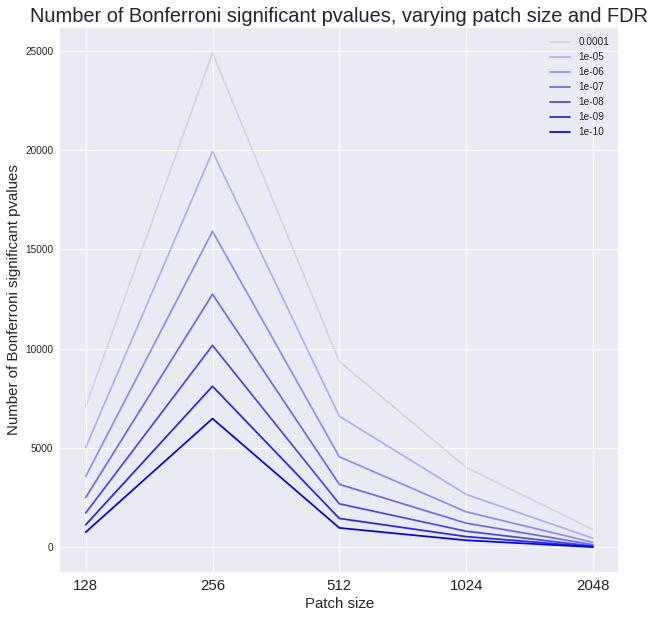

In [16]:
plt.figure(figsize=(10,10))
plt.title("Number of Bonferroni significant pvalues, varying patch size and FDR", size=20)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of Bonferroni significant pvalues',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=alph)[0]) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()

mean_128_R
mean_256_R
mean_512_R
mean_1024_R
mean_2048_R


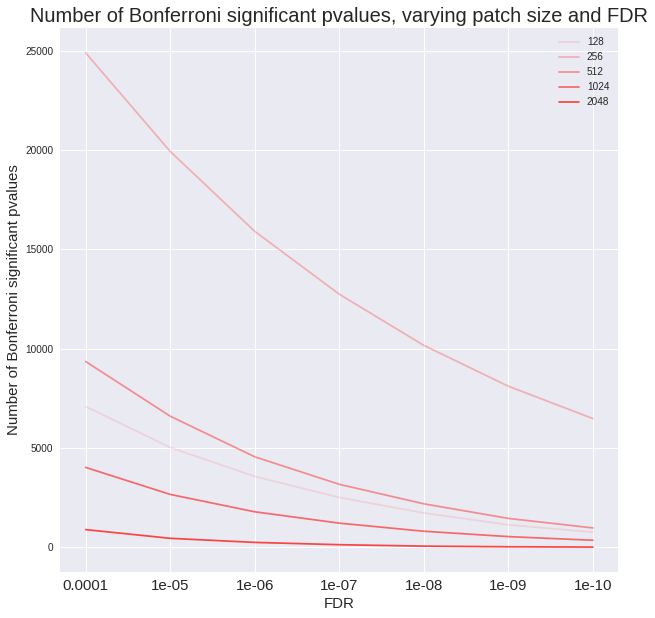

In [17]:

plt.figure(figsize=(10,10))
plt.title("Number of Bonferroni significant pvalues, varying patch size and FDR",size=20)

plt.xticks(range(len(alphas)),alphas,size=15)
plt.xlabel('FDR',size=15)
plt.ylabel('Number of Bonferroni significant pvalues',size=15)
for a in aggregations[0:1]:
    for (k,s) in enumerate(sizes):
        if a == 'mean':
            c = 'red'
        else:
            c = 'blue'
            
        assoc_key = '{}_{}_{}'.format(a,s,'R')
        print (assoc_key)
        associations = results[assoc_key]
        
        points = [sum(smm.multipletests(associations.flatten(),method='bonferroni',alpha=a)[0]) for a in alphas]
        plt.plot(points, c=c,label=s,alpha=0.1 + 0.15*k)
plt.legend()

        

# Comparing mean / median

## More associations using mean apart from at very large patch sizes.

mean_128_R
mean_256_R
mean_512_R
mean_1024_R
mean_2048_R
median_128_R
median_256_R
median_512_R
median_1024_R
median_2048_R


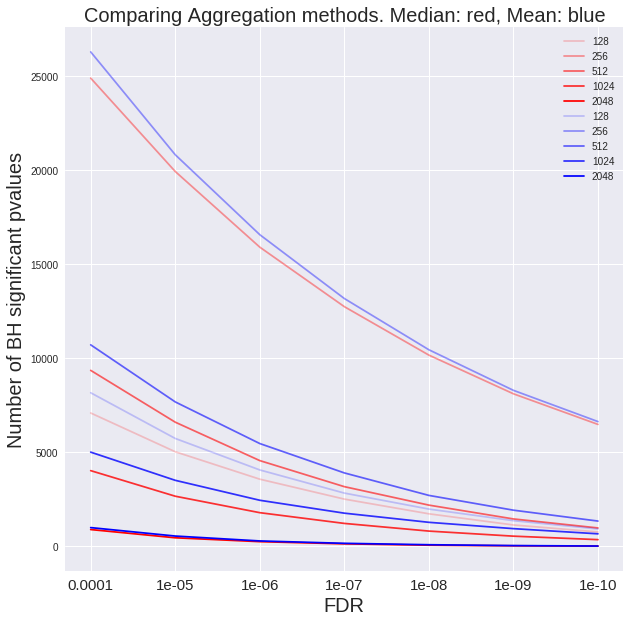

In [18]:

plt.figure(figsize=(10,10))
plt.title("Comparing Aggregation methods. Median: red, Mean: blue",size=20)
plt.xticks(range(len(alphas)),alphas,size=15)
plt.xlabel('FDR',size=20)
plt.ylabel('Number of BH significant pvalues',size=20)
for a in aggregations:
    for (k,s) in enumerate(sizes):
        if a == 'mean':
            c = 'red'
        else:
            c = 'blue'
            
        assoc_key = '{}_{}_{}'.format(a,s,'R')
        print (assoc_key)
        associations = results[assoc_key]
        
        points = [sum(smm.multipletests(associations.flatten(),method='bonferroni',alpha=a)[0]) for a in alphas]
        plt.plot(points, c=c,label=s,alpha=0.2 + 0.2*k)
plt.legend()

        

# Number of features that have significant associations - to account for SNPs in LD

In [ ]:
alphas = [0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]
sizes = [128,256,512,1024,2048]
aggregations = ['mean','median']

In [54]:
a = 'mean'
s = 128
pvalues = results['{}_{}_{}'.format(a,s,'R')]
sum(np.sum(smm.multipletests(pvalues.flatten(),method='bonferroni',alpha=0.001)[0].reshape(pvalues.shape),axis=1) > 0)

60

In [58]:
s = None

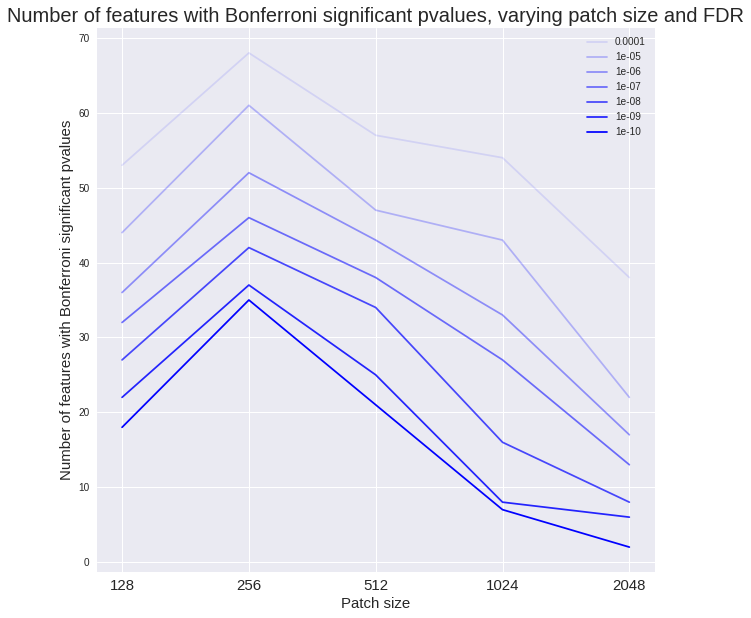

In [64]:
alphas = [0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]
sizes = [128,256,512,1024,2048]
aggregations = ['mean','median']
plt.figure(figsize=(10,10))
plt.title("Number of features with Bonferroni significant pvalues, varying patch size and FDR", size=20)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of features with Bonferroni significant pvalues',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(np.sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=alph)[0].reshape(results['{}_{}_{}'.format(a,s,'R')].shape),axis=1) > 0) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()

# Number of transcripts that have significant associations to at least 1 feature

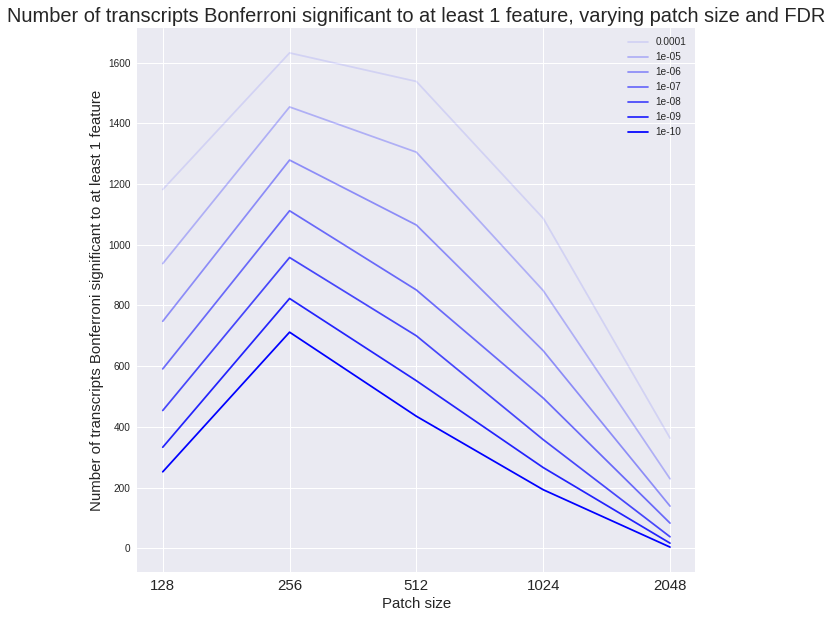

In [67]:
plt.figure(figsize=(10,10))
plt.title("Number of transcripts Bonferroni significant to at least 1 feature, varying patch size and FDR", size=20)
plt.xticks(range(len(alphas)),sizes,size=15)
plt.xlabel('Patch size',size=15)
plt.ylabel('Number of transcripts Bonferroni significant to at least 1 feature',size=15)
for a in aggregations[0:1]:
    for (k, alph) in enumerate(alphas):
        points = [sum(np.sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=alph)[0].reshape(results['{}_{}_{}'.format(a,s,'R')].shape),axis=0) > 0) for s in sizes]
#         points = [sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=alph)[0]) for s in sizes]
        plt.plot(points, c='blue',label=alph, alpha=0.1+0.15*k)
plt.legend()